In [1]:
import sys
import os
import seaborn as sns
sys.path.append("../")
from src.data.load_data import load_all_data, to_dF_F
from scipy.spatial.transform import Rotation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

## Load Data

In [3]:
project_dir = "/Users/anacarolinabotturabarros/PycharmProjects/RSCMINHD/"
animal = 'cohoHDC1_mB1'
session = "2023_03_10/12_51_18"
data_dict = load_all_data(animal,session, project_dir)
img_data = data_dict['img_data']
head_data = data_dict['head_data']
img_time_stamps = data_dict['img_time_stamps']

unit_id    0
frame      0
C          0
dtype: int64
Time Stamp (ms)    0
qw                 0
qx                 0
qy                 0
qz                 0
dtype: int64
Frame Number       0
Time Stamp (ms)    0
Buffer Index       0
dtype: int64


### Calculate dF/F and normalised calcium traces

Still need to figure out what is the best measure to use.

In [4]:
group_by_unit = img_data.groupby('unit_id')
df_units = []
normalised_c = []
for name, unit in group_by_unit:
    dFF = to_dF_F(unit)
    dFF.name = name
    df_units.append(dFF)
    min_C = unit['C'].min()
    max_C = unit['C'].max()
    min_max_norm = (unit['C']- min_C)/(max_C-min_C)
    normalised_c.append(min_max_norm)
    

# pd.concat(df_units, ignore_index=True, axis=1)
img_data['df/f'] = pd.concat(df_units)
img_data['norm_C'] = pd.concat(normalised_c)

## Plot a unit

Plotting some units might give some idea of what we have

<Axes: xlabel='frame', ylabel='norm_C'>

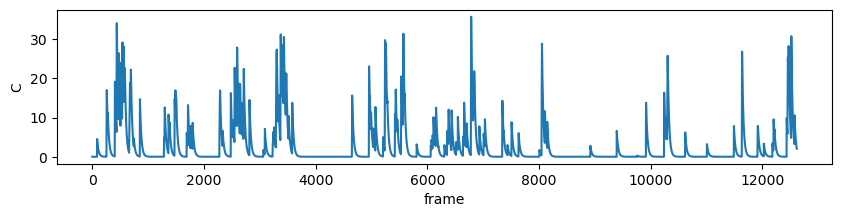

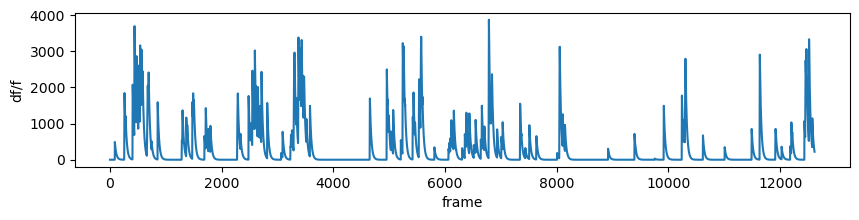

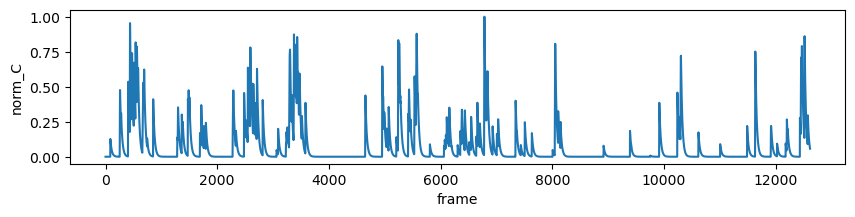

In [5]:
unit = 2

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='C')

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='df/f')

plt.figure(figsize=(10,2))
unit_data = img_data[img_data['unit_id']==img_data['unit_id'].unique()[unit]]
sns.lineplot(data=unit_data, x='frame',y='norm_C')

## Working with head orientation data

[Text(0, 0.5, 'Direction')]

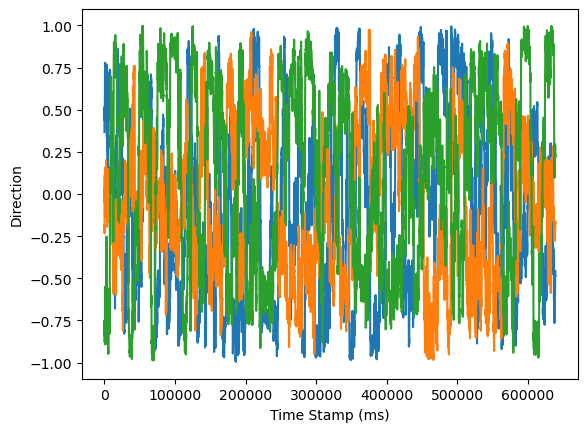

In [6]:
# plot variable from head orientation data
ax = sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qx')
sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qy')
sns.lineplot(data=head_data, x='Time Stamp (ms)',y='qz')
ax.set(ylabel='Direction')

Here we try to bin the different variables into a certain number of bins

In [7]:
bins = 11
head_data['binned_qx'] = pd.cut(head_data['qx'],np.linspace(-1,1,bins))
head_data['binned_qy'] = pd.cut(head_data['qy'],np.linspace(-1,1,bins))
head_data['binned_qz'] = pd.cut(head_data['qz'],np.linspace(-1,1,bins))
head_data['binned_qw'] = pd.cut(head_data['qw'],np.linspace(-1,1,bins))

Here we plot the the count of occurences per bin for each of the variables

Text(0, 0.5, 'Count')

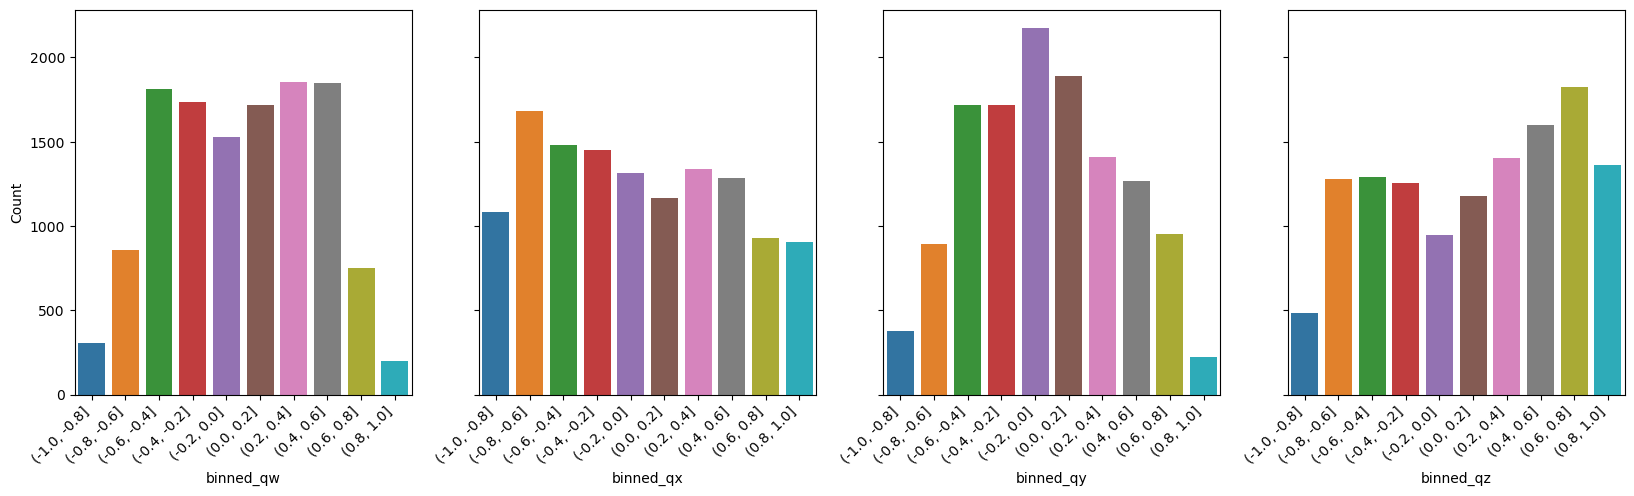

In [8]:

fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))
head_qua_vars = head_data.columns[1:]

for ax,var in zip(axs,head_qua_vars):
    p = sns.countplot(x=head_data['binned_'+var], ax=ax)
    ax.set_xticklabels(head_data['binned_qx'].cat.categories, rotation=45, ha='right')
    ax.set(ylabel=None)

axs[0].set_ylabel('Count')

### Transform quartenion data into Euler coordinates

Two ways of calculating the euler angles. One function (adapted to deal with long format data) or the scipy Rotation function.

In [9]:
import math
 
def euler_from_quaternion(x, y, z, w):
        """
        Convert a quaternion into euler angles (roll, pitch, yaw)
        roll is rotation around x in radians (counterclockwise)
        pitch is rotation around y in radians (counterclockwise)
        yaw is rotation around z in radians (counterclockwise)
        """
        t0 = +2.0 * (w * x + y * z)
        t1 = +1.0 - 2.0 * (x * x + y * y)
        roll_x = [math.atan2(i0, i1) for i0, i1 in zip(t0,t1)]
     
        t2 = +2.0 * (w * y - z * x)
        t2 = [+1.0 if i2 > +1.0 else i2 for i2 in t2]
        t2 = [-1.0 if i2 < -1.0 else i2 for i2 in t2]
        pitch_y = [math.asin(i2) for i2 in t2]
     
        t3 = +2.0 * (w * z + x * y)
        t4 = +1.0 - 2.0 * (y * y + z * z)
        yaw_z = [math.atan2(i3, i4) for i3, i4 in zip(t3, t4)]
     
        return roll_x, pitch_y, yaw_z # in radians

In [10]:
x, y, z = euler_from_quaternion(head_data['qx'], head_data['qy'], head_data['qz'], head_data['qw'])
print(x[0],y[0],z[0])

0.037327955424233436 0.8496204042712617 2.2831640727103486


In [11]:
quat = np.array([head_data['qx'], head_data['qy'], head_data['qz'], head_data['qw']])
R = Rotation.from_quat(quat.T)
quat.T.shape
print(quat.T[0])
print(R.as_quat()[0])
euler_data = R.as_euler('xyz', degrees=True)
print(R.as_euler('xyz')[0])

[ 0.367615 -0.186951 -0.825134 -0.386108]
[ 0.36761188 -0.18694941 -0.825127   -0.38610472]
[0.037327   0.8496011  2.28314462]


Combining euler data to original head orientation data and saving it

In [12]:
head_data = pd.concat([head_data, pd.DataFrame(euler_data, columns=['roll_x', 'pitch_y', 'yaw_z'])], axis=1)

In [13]:
# bin euler variables
bins = 61
head_data['binned_roll_x'] = pd.cut(head_data['roll_x'],np.linspace(-180,180,bins))
head_data['binned_pitch_y'] = pd.cut(head_data['pitch_y'],np.linspace(-90,90,bins))
head_data['binned_yaw_z'] = pd.cut(head_data['yaw_z'],np.linspace(-180,180,bins))

In [14]:
head_data['frame'] = head_data.index
head_data.to_csv(os.path.join(project_dir,'data/processed', animal, session,'headOrientationProc.csv'))

## Finding intervals for the different bins

In [15]:
import itertools
from operator import itemgetter

def find_intervals(data):
    ranges =[]    
    for key, group in itertools.groupby(enumerate(data), lambda x:x[0]-x[1]):
        group = list(map(itemgetter(1), group))
        if len(group) > 1:
            ranges.append(pd.Interval(group[0], group[-1],closed='both'))
        # else:
        #     ranges.append(group[0])
    return ranges

def get_intervals(head_data, variable):
    """get frame intervals where angles are within the specified bin

    :param head_data: head orientation data
    :type head_data: pd.DataFrame
    :param variable: name of the variable in head_data to base intervals
    :type variable: str
    :return: intervals of frames with angles between specific groups
    :rtype: dict
    """
    grouped = head_data[[variable,'frame']].groupby(variable)
    intervals = {}
    for name, group in grouped:
        intervals[name] = find_intervals(group['frame'])
    return intervals
     

In [16]:
# Find intervals for one of the quartenion variables
intervals = get_intervals(head_data,'binned_qx')

# Find intervals for yaw_z
intervals_yaw = get_intervals(head_data,'binned_yaw_z')


## Calculate the area under the curve for all intervals per bin and per unit 

In [17]:
def calculate_auc(unit_data, intervals):
    # calculate the area under the curve norm_C for each unit between intervals found and sum the area under the curve
    """_summary_

    :param unit_data: _description_
    :type unit_data: _type_
    :param intervals: _description_
    :type intervals: _type_
    :return: _description_
    :rtype: _type_
    """
    
    all_auc = pd.DataFrame()

    for key, value in intervals.items():
        auc_dict = {}
        for name, unit in unit_data:
            auc=0
            for i in value:
                img_interval = unit[unit['frame'].between(i.left, i.right)]
                auc += np.trapz(img_interval['norm_C'],img_interval['frame'])
            auc_dict[name] = auc
        all_auc[key] = pd.Series(auc_dict)
    
    return all_auc

def calculate_int_length(intervals):
    """Calculate the length of the intervals for a dictionary of intervals and return the total sum of the lengths for a range of angles.

    :param intervals: Dictionary of intervals
    :type intervals: dict
    :return: dictionary of total sum of lengths
    :rtype: dict
    """
    interval_lengths = {}
    for itv in intervals.keys():
        int_idx = pd.IntervalIndex(intervals[itv])
        total_time = np.sum(int_idx.right - int_idx.left +1)
        interval_lengths[itv] = total_time
    return interval_lengths

In [18]:
# calculate the area under the curve norm_C for each unit between intervals found
all_auc = calculate_auc(img_data.groupby('unit_id'), intervals)
# print(all_auc.head())
interval_lengths = calculate_int_length(intervals)
interval_lengths = pd.Series(interval_lengths, name='interval_lengths')
dir_tuning = all_auc.T.div(interval_lengths, axis=0).T

In [19]:
# for intervals based on yaw
all_auc_yaw = calculate_auc(img_data.groupby('unit_id'), intervals_yaw)
# print(all_auc_yaw.head())
interval_yaw_lengths = calculate_int_length(intervals_yaw)
interval_yaw_lengths = pd.Series(interval_yaw_lengths, name='interval_lengths')
dir_tuning_yaw = all_auc_yaw.T.div(interval_yaw_lengths, axis=0).T

In [20]:
dir_tuning

(-1.0, -0.8]  (-0.8, -0.6]  (-0.6, -0.4]  (-0.4, -0.2]  (-0.2, 0.0]  \
1        0.015741      0.016805      0.032085      0.031310     0.035384   
4        0.184157      0.217083      0.298475      0.252064     0.263899   
13       0.107595      0.082851      0.076119      0.088481     0.069100   
15       0.015248      0.039665      0.074203      0.034480     0.044648   
16       0.009886      0.027020      0.046599      0.033376     0.039376   
..            ...           ...           ...           ...          ...   
179      0.014909      0.028945      0.063232      0.038239     0.034900   
181      0.192429      0.196077      0.170857      0.194623     0.214796   
183      0.019613      0.034693      0.081528      0.045759     0.045688   
184      0.196438      0.176422      0.159974      0.143977     0.177884   
185      0.013792      0.024545      0.047949      0.031064     0.037045   

     (0.0, 0.2]  (0.2, 0.4]  (0.4, 0.6]  (0.6, 0.8]  (0.8, 1.0]  
1      0.045561    0.053393    0.028436    0.067718    0.024538  
4      0.322691    0.316038    0.337506    0.299942    0.295786  
13     0.075607    0.053874    0.050921    0.031170    0.025003  
15     0.072705    0.071013    0.087119    0.075940    0.051628  
16     0.067762    0.075338    0.077757    0.065271    0.065292  
..          ...         ...         ...         ...         ...  
179    0.047096    0.060849    0.060416    0.062950    0.025474  
181    0.228932    0.203565    0.188433    0.207920    0.215630  
183    0.057673    0.074197    0.083817    0.062182    0.026104  
184    0.177935    0.181772    0.165043    0.173602    0.176472  
185    0.043041    0.061606    0.054214    0.062190    0.020257  

[108 rows x 10 columns]

## Visualise direction tuning

/var/folders/hr/l2d8lwfs1fs94d4mll4lzh7w0000gp/T/ipykernel_46950/3091036241.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(plot_unit.variable.astype(str), rotation=45, ha='right')


[Text(0, 0.5, 'Direction Tunning'), Text(0.5, 0, 'Direction qx')]

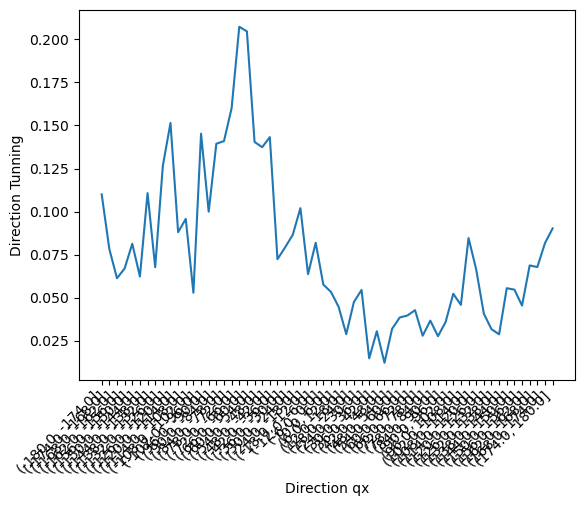

In [24]:
dir_tuning_yaw['unit_id']=dir_tuning_yaw.index
new_melt = pd.melt(dir_tuning_yaw, id_vars='unit_id')

unit = 90
plot_unit = new_melt[new_melt.unit_id == new_melt.unit_id.unique()[unit]]
ax = sns.lineplot(plot_unit, x=plot_unit.variable.astype(str), y='value')
ax.set_xticklabels(plot_unit.variable.astype(str), rotation=45, ha='right')
ax.set(ylabel='Direction Tunning',xlabel='Direction qx')

In [25]:
plot_unit.loc[:,'degree'] = pd.IntervalIndex(plot_unit['variable']).left*np.pi/180
# plot_unit['variable'] = pd.IntervalIndex(plot_unit.variable)
# type(plot_unit.variable.iloc[0])
plot_unit['degree']

/var/folders/hr/l2d8lwfs1fs94d4mll4lzh7w0000gp/T/ipykernel_46950/2763183025.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_unit.loc[:,'degree'] = pd.IntervalIndex(plot_unit['variable']).left*np.pi/180


90     -3.141593
198    -3.036873
306    -2.932153
414    -2.827433
522    -2.722714
630    -2.617994
738    -2.513274
846    -2.408554
954    -2.303835
1062   -2.199115
1170   -2.094395
1278   -1.989675
1386   -1.884956
1494   -1.780236
1602   -1.675516
1710   -1.570796
1818   -1.466077
1926   -1.361357
2034   -1.256637
2142   -1.151917
2250   -1.047198
2358   -0.942478
2466   -0.837758
2574   -0.733038
2682   -0.628319
2790   -0.523599
2898   -0.418879
3006   -0.314159
3114   -0.209440
3222   -0.104720
3330    0.000000
3438    0.104720
3546    0.209440
3654    0.314159
3762    0.418879
3870    0.523599
3978    0.628319
4086    0.733038
4194    0.837758
4302    0.942478
4410    1.047198
4518    1.151917
4626    1.256637
4734    1.361357
4842    1.466077
4950    1.570796
5058    1.675516
5166    1.780236
5274    1.884956
5382    1.989675
5490    2.094395
5598    2.199115
5706    2.303835
5814    2.408554
5922    2.513274
6030    2.617994
6138    2.722714
6246    2.827433
6354    2.9321

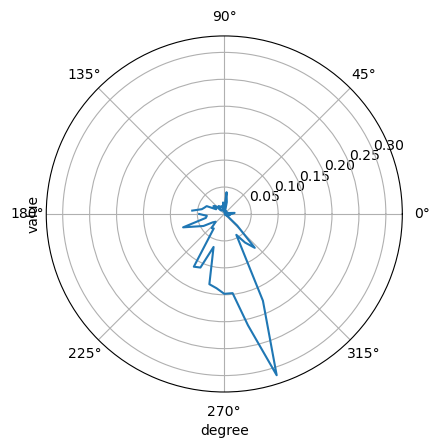

In [23]:
g = sns.FacetGrid(plot_unit, subplot_kws=dict(projection='polar'), height=4.5, sharex=False, sharey=False, despine=False)
g.map(sns.lineplot,"degree","value")

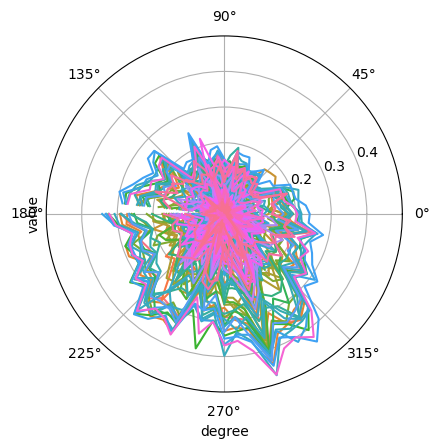

In [26]:
new_melt.loc[:,'degree'] = pd.IntervalIndex(new_melt['variable']).left*np.pi/180
g = sns.FacetGrid(new_melt, hue='unit_id',subplot_kws=dict(projection='polar'), height=4.5, sharex=False, sharey=False, despine=False)
g.map(sns.lineplot,"degree","value")

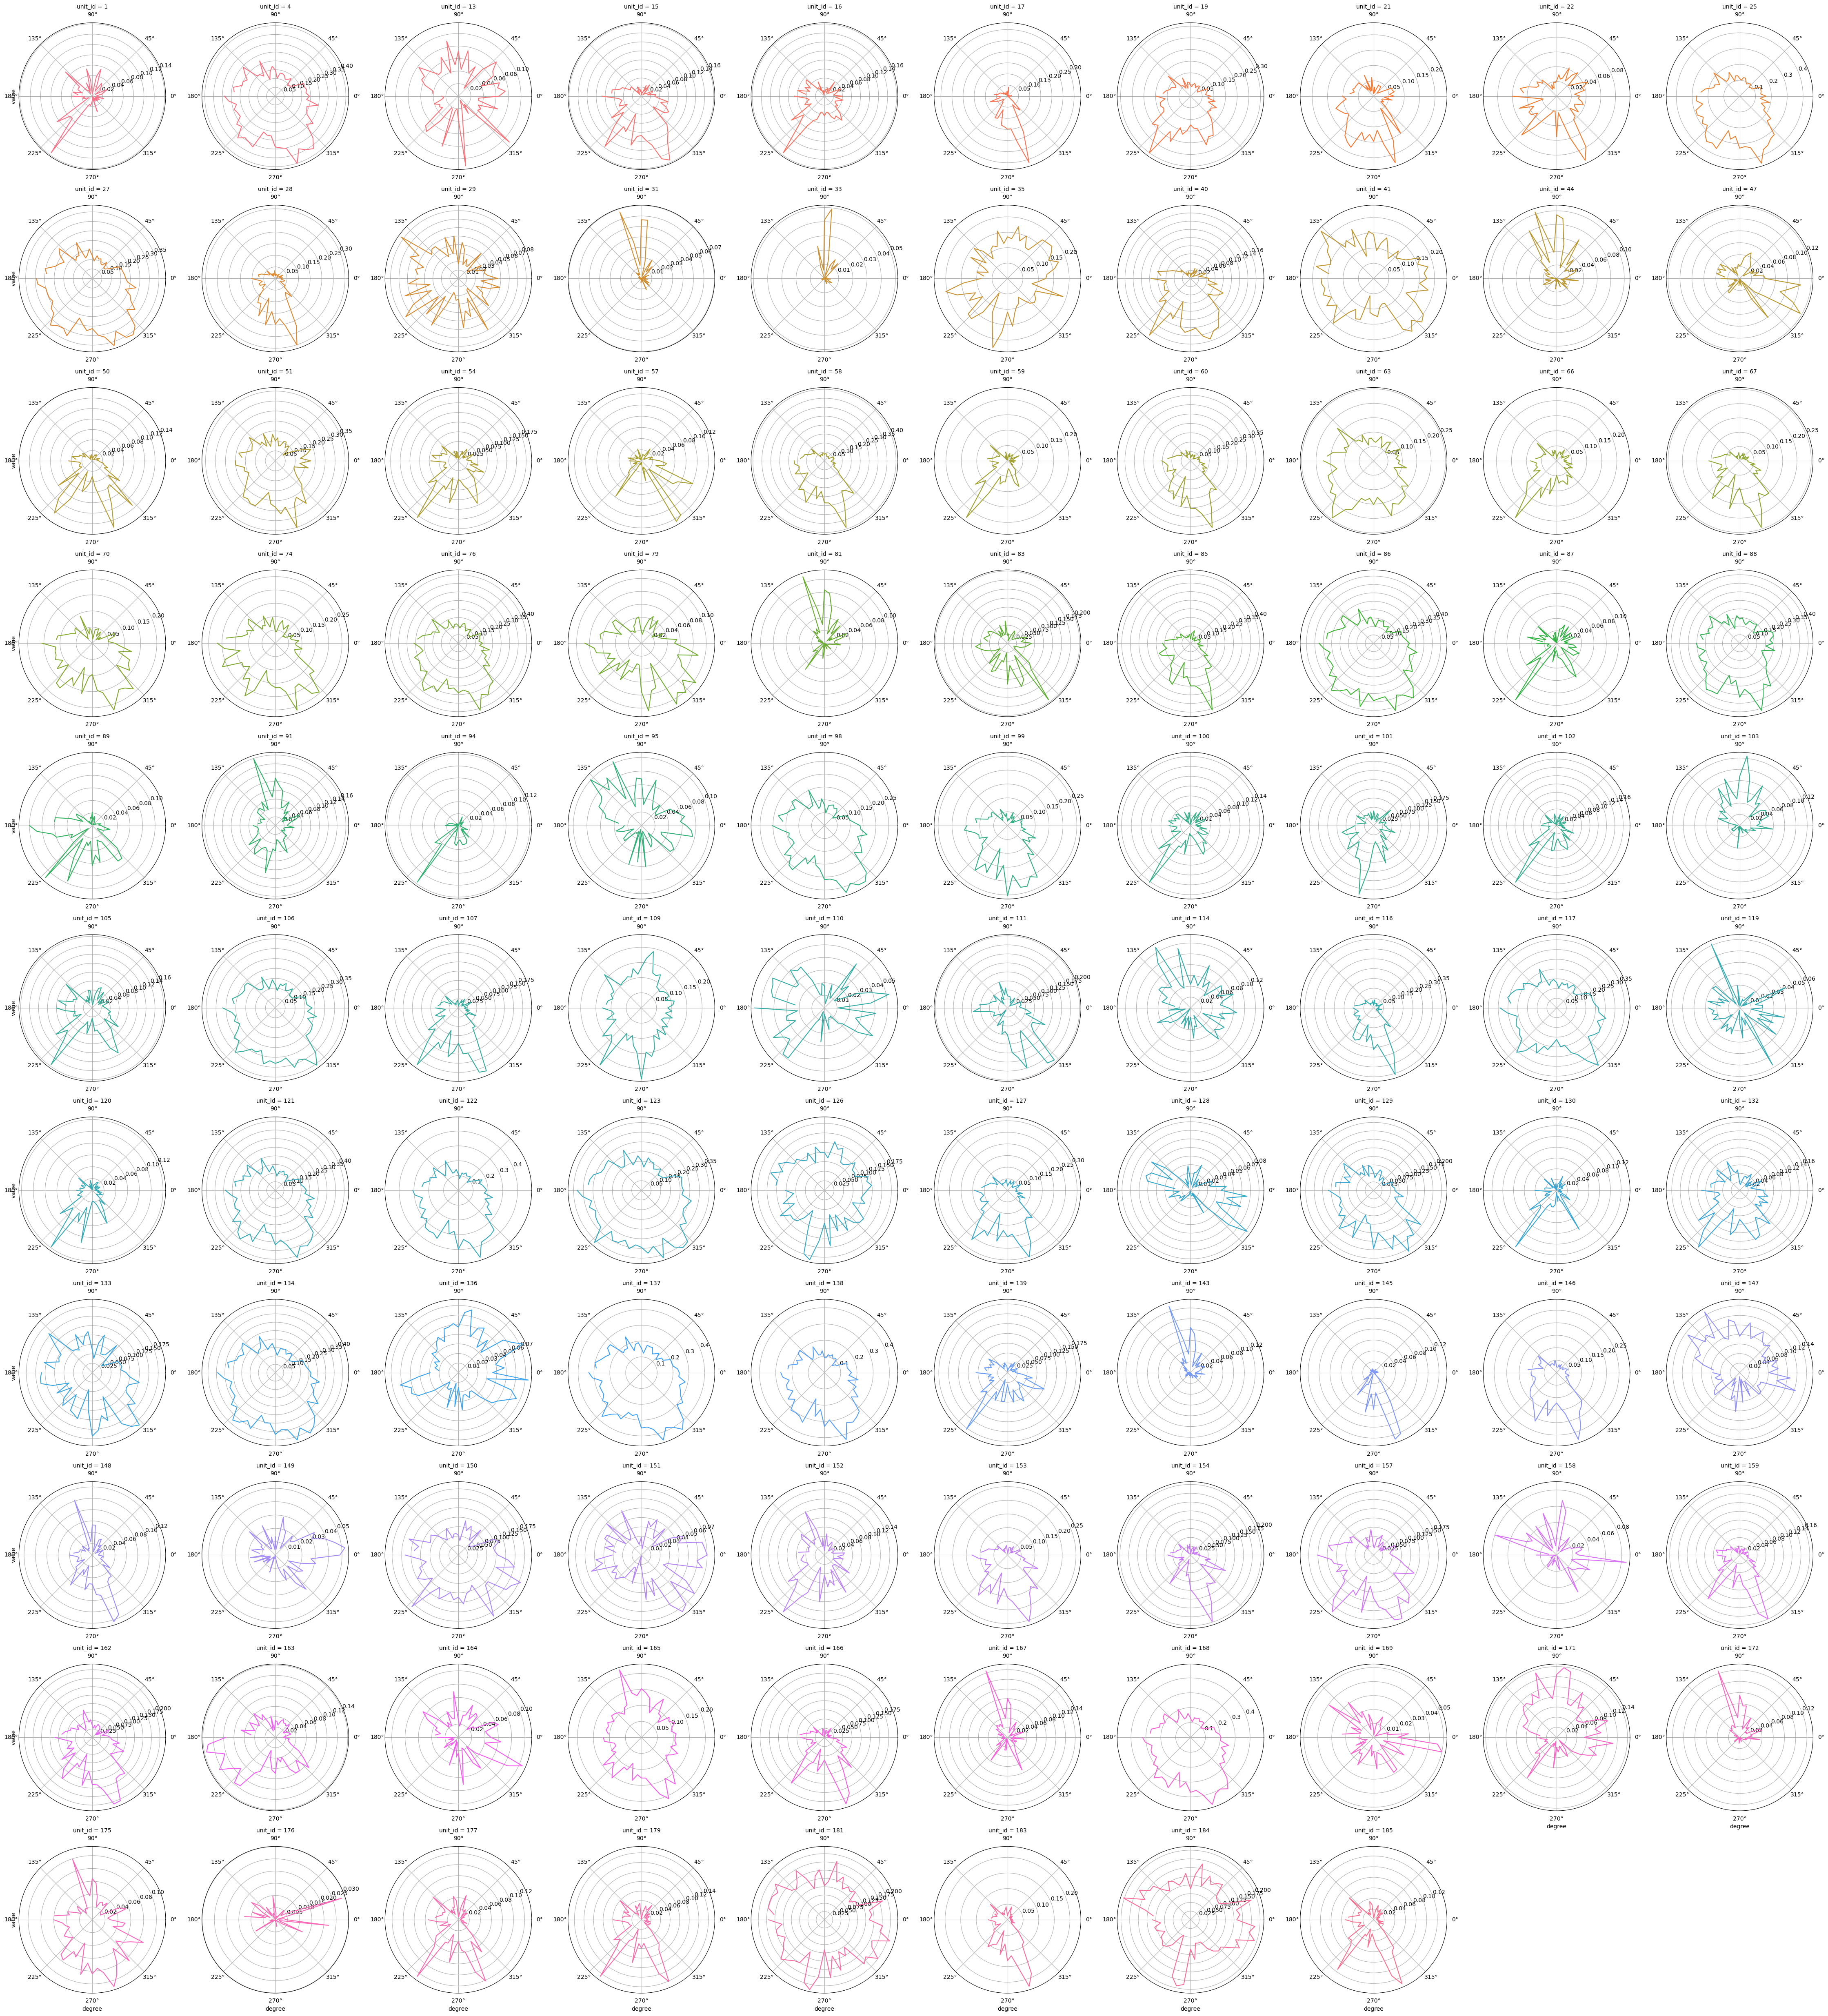

In [29]:
new_melt.loc[:,'degree'] = pd.IntervalIndex(new_melt['variable']).left*np.pi/180
g = sns.FacetGrid(new_melt, col='unit_id', col_wrap=10,hue='unit_id',subplot_kws=dict(projection='polar'), height=4.5, sharex=False, sharey=False, despine=False)
g.map(sns.lineplot,"degree","value")

In [32]:
g.savefig(os.path.join(project_dir,"reports/figures","all_ROIs.png"))

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (60).

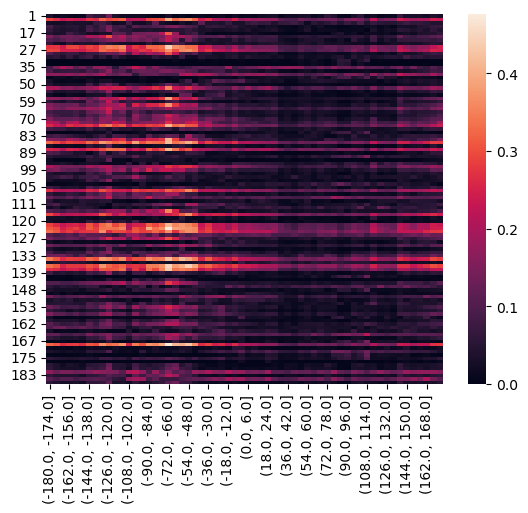

In [27]:
ax = sns.heatmap(dir_tuning_yaw.iloc[:,:-1])
ax.set_xticklabels(plot_unit.variable.astype(str), rotation=45, ha='right')
ax.set(ylabel='Units', xlabel='Direction')

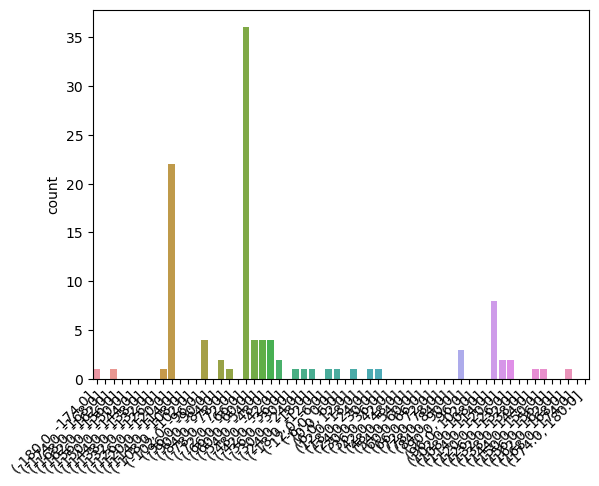

In [28]:
df=dir_tuning_yaw.iloc[:,:-1].T
pref_dir = df.idxmax()
pref_dir.value_counts()
ax = sns.countplot(x=pref_dir.values, order=df.index)
t = ax.set_xticklabels(df.index, rotation=45, ha='right')